# Virtual Sites Showcase

In [1]:
import time

import openmm
import openmm.app
import openmm.unit
from openff.interchange import Interchange

from openff.toolkit import ForceField, Molecule, Topology

In [2]:
def prepare_simulation(interchange: Interchange) -> openmm.app.Simulation:
    """Propagate an OpenMM System with Langevin dynamics."""
    time_step = 2 * openmm.unit.femtoseconds
    temperature = 300 * openmm.unit.kelvin
    friction = 1 / openmm.unit.picosecond
    integrator = openmm.LangevinIntegrator(temperature, friction, time_step)

    trj_freq, data_freq = 100, 100

    simulation = interchange.to_openmm_simulation(integrator=integrator)

    # It's important to run energy minimization before computing velocities; otherwise the initial
    # velocities may be too high as a result of high initial forces, causing a crash
    # See https://github.com/openmm/openmm/issues/3736#issuecomment-1217250635
    simulation.minimizeEnergy()

    # Since we placed all virtual sites at [0.0, 0.0, 0.0], compute virtual site positions to avoid a crash
    simulation.context.computeVirtualSites()

    simulation.context.setVelocitiesToTemperature(temperature)

    pdb_reporter = openmm.app.PDBReporter("trajectory.pdb", trj_freq)
    state_data_reporter = openmm.app.StateDataReporter(
        "data.csv",
        data_freq,
        step=True,
        potentialEnergy=True,
        temperature=True,
        density=True,
    )
    simulation.reporters.append(pdb_reporter)
    simulation.reporters.append(state_data_reporter)

    return simulation


def run_simulation(simulation: openmm.app.Simulation, num_steps: int = 1000):
    print("Starting simulation")
    start = time.process_time()

    simulation.step(num_steps)

    end = time.process_time()
    print("Elapsed time %.2f seconds" % (end - start))
    print("Done!")

## Part 1: Run a short simulation with a virtual sites on sulfur lone pair and chloride groups

In [3]:
vsite_offxml = """<?xml version="1.0" encoding="utf-8"?>
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <VirtualSites version="0.3">
        <VirtualSite
            type="DivalentLonePair"
            name="EP"
            smirks="[*:2]-[#16X2:1]-[*:3]"
            distance="0.70 * angstrom"
            charge_increment1="0.1205*elementary_charge"
            charge_increment2="0.0*elementary_charge"
            charge_increment3="0.1205*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.0*kilocalories_per_mole"
            outOfPlaneAngle="54.71384225*degree"
            match="all_permutations" >
        </VirtualSite>
        <VirtualSite
            type="BondCharge"
            name="EP"
            smirks="[*:2][Cl:1]"
            distance="0.4*angstrom"
            charge_increment1="0.2*elementary_charge"
            charge_increment2="0.0*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.05*kilocalories_per_mole"
            match="all_permutations" >
        </VirtualSite>
        <VirtualSite
            type="BondCharge"
            name="EP"
            smirks="[*:2][F:1]"
            distance="0.4*angstrom"
            charge_increment1="0.2*elementary_charge"
            charge_increment2="0.0*elementary_charge"
            sigma="0.1*angstrom"
            epsilon="0.05*kilocalories_per_mole"
            match="all_permutations" >
        </VirtualSite>
    </VirtualSites>
</SMIRNOFF>
"""
force_field = ForceField("openff-2.1.0.offxml", vsite_offxml)

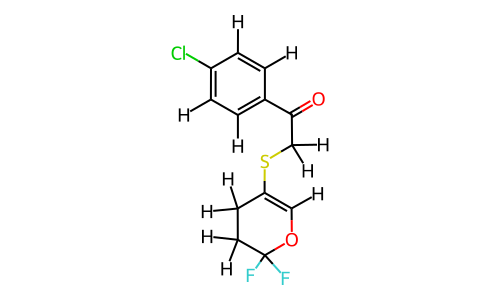

In [4]:
molecule = Molecule.from_smiles("c1cc(Cl)ccc1C(=O)CS[C]1=CO[C](F)(F)CC1")
molecule.generate_conformers(n_conformers=1)
molecule.visualize()

In [5]:
# Create an Interchange object, which stores information needed for OpenMM (and other engines)
# to understand virtual sites as applied by a force field

interchange = force_field.create_interchange(topology=molecule.to_topology())

assert "VirtualSites" in interchange.collections.keys()

n_virtual_sites = len(interchange.collections["VirtualSites"].key_map)

print(f"There are {n_virtual_sites} virtual particles in this topology.")

There are 5 virtual particles in this topology.


At this point, each of our OpenFF objects have processed and stored all of the information needed to run a simulation in OpenMM. Different [OpenMM objects](https://docs.openforcefield.org/projects/interchange/en/stable/using/output.html#openmm) can be created from an `Interchange` object:

* `openmm.System`: `Interchange.to_openmm()`
* `openmm.app.Topology`: `Interchange.to_openmm_topology()`
* `openmm.app.Simulation`: `Interchange.to_openmm_simulation()`

For simplicity, we'll just create a `Simulation` object with the function we defined above since that's all we need to run a simulation in OpenMM.

In [6]:
simulation = prepare_simulation(interchange)

run_simulation(simulation, 10000)

VirtualSiteTypeNotImplementedError: Only symmetric geometries (i.e. r2 - r0 = r1 - r0) are currently supported

In [ ]:
import mdtraj

# Visualize the trajectory. There will probably be errant bonds drawn between atoms and virtual sites.
import nglview

nglview.show_mdtraj(mdtraj.load("trajectory.pdb"))

## Part 2: Comparison of SMIRNOFF and OpenMM implementations of TIP5P

In [ ]:
tip5p_offxml = """<?xml version="1.0" encoding="utf-8"?>
<SMIRNOFF version="0.3" aromaticity_model="OEAroModel_MDL">
    <LibraryCharges version="0.3">
            <LibraryCharge
                name="tip5p"
                smirks="[#1:1]-[#8X2H2+0:2]-[#1:3]"
                charge1="0.*elementary_charge"
                charge2="0.*elementary_charge"
                charge3="0.*elementary_charge"
            />
    </LibraryCharges>
    <vdW version="0.3"
        potential="Lennard-Jones-12-6"
        combining_rules="Lorentz-Berthelot"
        scale12="0.0"
        scale13="0.0"
        scale14="0.5"
        scale15="1.0"
        switch_width="0.0 * angstrom"
        cutoff="10.0 * angstrom"
        method="cutoff"
        >
        <Atom
            smirks="[#1:1]-[#8X2H2+0]-[#1]"
            epsilon="0. * mole**-1 * kilojoule"
            id="n35"
            sigma="1.0 * nanometer"
        />
        <Atom
            smirks="[#1]-[#8X2H2+0:1]-[#1]"
            epsilon="0.66944 * mole**-1 * kilojoule"
            id="n35"
            sigma="0.312 * nanometer"
        />
    </vdW>
    <VirtualSites version="0.3">
        <VirtualSite
            type="DivalentLonePair"
            name="EP"
            smirks="[#1:2]-[#8X2H2+0:1]-[#1:3]"
            distance="0.70 * angstrom"
            charge_increment1="0.0*elementary_charge"
            charge_increment2="0.1205*elementary_charge"
            charge_increment3="0.1205*elementary_charge"
            sigma="10.0*angstrom"
            epsilon="0.0*kilocalories_per_mole"
            outOfPlaneAngle="54.735*degree"
            match="all_permutations"
        >
        </VirtualSite>
    </VirtualSites>
    <Constraints version="0.3">
        <Constraint
            smirks="[#1:1]-[#8X2H2+0:2]-[#1]"
            id="c1"
            distance="0.9572 * angstrom"
            />
        <Constraint
            smirks="[#1:1]-[#8X2H2+0]-[#1:2]"
            id="c2"
            distance="1.5139006545247014 * angstrom"
        />
    </Constraints>
    <Electrostatics
        version="0.3"
        method="PME"
        scale12="0.0"
        scale13="0.0"
        scale14="0.833333"
        scale15="1.0"
        switch_width="0.0 * angstrom"
        cutoff="9.0 * angstrom"
    />
</SMIRNOFF>
"""

In [ ]:
water = Molecule.from_mapped_smiles("[O:1]([H:2])[H:3]")
water.generate_conformers()

with open("smirnoff.xml", "w") as f:
    f.write(
        openmm.XmlSerializer.serialize(
            ForceField(tip5p_offxml).create_openmm_system(
                Topology.from_molecules([water])
            )
        )
    )

In [ ]:
topology = Topology.from_molecules([water])
_topology: openmm.app.Topology = topology.to_openmm()

atom_positions = topology.get_positions().to_openmm()

# Use OpenMM's Modeller to add virtual particles as perscribed by the force field
modeller = openmm.app.Modeller(_topology, atom_positions)
modeller.addExtraParticles(openmm.app.ForceField("tip5p.xml"))

# This topology includes virtual sites, so we can use it to create a System
topology_with_virtual_sites = modeller.getTopology()

with open("openmm.xml", "w") as f:
    f.write(
        openmm.XmlSerializer.serialize(
            openmm.app.ForceField("tip5p.xml").createSystem(
                topology_with_virtual_sites,
                nonbondedMethod=openmm.app.NoCutoff,
                constraints=openmm.app.HAngles,
                removeCMMotion=False,
            )
        )
    )

In [ ]:
!diff smirnoff.xml openmm.xml

We can see by comparing the two resulting XMLs that the differences are inconsequential.
* Some virtual site weights are rounded to different precisions
* Exceptions are listed in different order
* Some exceptions list atoms in the opposite, which is okay since exceptions are symmetric
* OpenMM adds empty forces for bond and angle interactions that do not exist